<center> Análise exploratória dos dados: Geração por usina em base horária </center>


Primeiro, faremos a importação das bibliotecas que serão utilizadas nessa análise exploratória:

In [318]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from glob import glob
from datetime import datetime
from IPython.display import display
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import xgboost as xgb
%matplotlib inline 

Carregamento dos dados de treino (Anos 2014 a 2018) em um só DataFrame:

In [319]:
arquivos = glob("C:/Users/ppgar/OneDrive/Documentos/Dados/Treino/*.csv")
treino = pd.DataFrame([])
for arquivo in arquivos:
    dados = pd.read_csv(arquivo, sep = ";")
    treino = pd.concat([treino, dados])
    print(arquivo, "carregado.")

C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2000.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2001.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2002.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2003.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2004.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2005.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2006.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2007.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2008.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2009.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2010.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2011.csv carregado.
C:/Users/ppgar/O

Podemos fazer uma visualização dos dados rápida dos dados do início do DataFrame e do final, para termos uma idéia de como ele é formado:

In [320]:
display(treino.head())
display(treino.tail())

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
0,2000-01-01 00:00:00,N,NORTE,PA,PARA,TIPO I,HIDROELÉTRICA,Hidráulica,Tucuruí,UHE.PH.PA.002889-4.01,2422.5,NaN
1,2000-01-01 00:00:00,NE,NORDESTE,AL,ALAGOAS,TIPO I,HIDROELÉTRICA,Hidráulica,Xingó,UHE.PH.SE.027053-9.01,1995.6,NaN
2,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidroelétricas da Chesf,-,13.0,NaN
3,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Apolônio Sales,UHE.PH.AL.001510-5.01,202.5,NaN
4,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Paulo Afonso II,UHE.PH.BA.027048-2.01,269.8,NaN


,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
4288651,2018-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Colorado,UTE.AI.SP.028094-1.01,21.000,NaN
4288652,2018-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Guarani Cruz Alta,UTE.AI.SP.027796-7.01,13.000,NaN
4288653,2018-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,São Salvador,UHE.PH.TO.028567-6.01,119.600,NaN
4288654,2018-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Lajeado,UHE.PH.TO.001304-8.01,476.403,NaN
4288655,2018-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Peixe Angical,UHE.PH.TO.028353-3.01,301.851,NaN


Como iremos fazer uma análise sobre a série histórica dos subsistemas e do Brasil inteiro, iremos utilizar apenas os valores da geração de energia agrupados por mês e subsistema, e suas respectivas datas. Assim, podemos excluir as colunas que não serão utilizadas na análise para poupar tempo e memória utilizada. Faremos também um tratamento de data e hora, para podermos agrupar a geração de energia por mês:

In [321]:

#-----------------------Tratamento de data e hora ----------------------_#
treino['din_instante'] = pd.to_datetime(treino['din_instante'])
treino['din_instante'] = treino['din_instante'].dt.strftime('%Y-%m')
#-----------------------Renomeanto a coluna 'din_instante' para 'data'------------------------#
treino = treino.rename(columns = {'din_instante': 'data'})

Quais são os subsistemas presentes nos dados?

In [322]:
display(pd.unique(treino['id_subsistema']))

array(['N', 'NE', 'S', 'SE'], dtype=object)

Agora, agruparemos os dados de treino pelo seu subsistema, para realizarmos uma análise da geração de energia ao longo do tempo, por subsistema:

In [323]:
norte = treino[treino['id_subsistema'] == "N"]
nordeste = treino[treino['id_subsistema'] == "NE"]
sul = treino[treino['id_subsistema'] == "S"]
sudeste = treino[treino['id_subsistema'] == "SE"]

In [324]:
display(treino)

,data,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
0,2000-01,N,NORTE,PA,PARA,TIPO I,HIDROELÉTRICA,Hidráulica,Tucuruí,UHE.PH.PA.002889-4.01,2422.500,NaN
1,2000-01,NE,NORDESTE,AL,ALAGOAS,TIPO I,HIDROELÉTRICA,Hidráulica,Xingó,UHE.PH.SE.027053-9.01,1995.600,NaN
2,2000-01,NE,NORDESTE,BA,BAHIA,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidroelétricas da Chesf,-,13.000,NaN
3,2000-01,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Apolônio Sales,UHE.PH.AL.001510-5.01,202.500,NaN
4,2000-01,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Paulo Afonso II,UHE.PH.BA.027048-2.01,269.800,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4288651,2018-12,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Colorado,UTE.AI.SP.028094-1.01,21.000,NaN
4288652,2018-12,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Guarani Cruz Alta,UTE.AI.SP.027796-7.01,13.000,NaN
4288653,2018-12,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,São Salvador,UHE.PH.TO.028567-6.01,119.600,NaN
4288654,2018-12,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Lajeado,UHE.PH.TO.001304-8.01,476.403,NaN


In [347]:
norte = norte.groupby('data').sum('val_geracao')
sul = sul.groupby('data').sum('val_geracao')
sudeste = sudeste.groupby('data').sum('val_geracao')
nordeste = nordeste.groupby('data').sum('val_geracao')

brasil = pd.DataFrame()
brasil['val_geracao'] = norte['val_geracao'] + sul['val_geracao'] + sudeste['val_geracao'] + nordeste['val_geracao']
display(brasil.head())

,val_geracao
data,
2000-01,2.957322e+07
2000-02,2.863598e+07
2000-03,3.047048e+07
2000-04,2.922538e+07
2000-05,3.014835e+07


Cálculo da tendência da série histórica de cada subsistema:

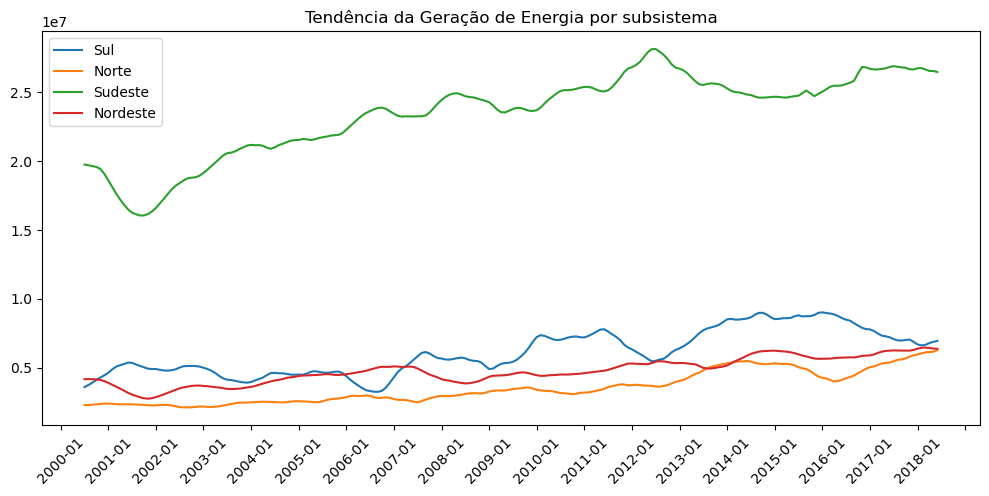

In [326]:
decompositionN = seasonal_decompose(norte, model='multiplicative', period=12)  # decomposição anual
decompositionNE = seasonal_decompose(nordeste, model='multiplicative', period=12)  # decomposição anual
decompositionSE = seasonal_decompose(sudeste, model='multiplicative', period=12)  # decomposição anual
decompositionS = seasonal_decompose(sul, model='multiplicative', period=12)  # decomposição anual



#---------------------------Criação do gráfico das tendências ---------------------------#
plt.figure(figsize = [10, 5])
plt.plot(decompositionS.trend, label = "Sul")
plt.plot(decompositionN.trend, label = "Norte")
plt.plot(decompositionSE.trend, label = "Sudeste")
plt.plot(decompositionNE.trend, label = "Nordeste")

#-------------------------------Configurações do gráfico -------------------------------#
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
plt.xticks(rotation = 45)
plt.tight_layout()
plt.title("Tendência da Geração de Energia por subsistema")
plt.show()


Carregando os arquivos de validação (Anos 2019 e 2020):

In [327]:
arquivos = glob("C:/Users/ppgar/OneDrive/Documentos/Dados/Validacao/*.csv")
validacao = pd.DataFrame([])
for arquivo in arquivos:
    dados = pd.read_csv(arquivo, sep = ";")
    print(arquivo, "carregado.")
    validacao = pd.concat([validacao, dados])

C:/Users/ppgar/OneDrive/Documentos/Dados/Validacao\GERACAO_USINA_2019.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Validacao\GERACAO_USINA_2020.csv carregado.


In [328]:
display(validacao.head())
display(validacao.tail())

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
0,2019-01-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,HIDROELÉTRICA,Hidráulica,Balbina,UHE.PH.AM.000190-2.01,82.993,NaN
1,2019-01-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO III,TÉRMICA,Óleo Diesel,Flores 4,UTE.PE.AM.029192-7.01,14.032,NaN
2,2019-01-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,TÉRMICA,Gás,Ponta Negra,UTE.GN.AM.029361-0.02,65.343,NaN
3,2019-01-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,TÉRMICA,Gás,Tambaqui,UTE.PE.AM.029276-1.01,50.980,NaN
4,2019-01-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO III,TÉRMICA,Óleo Combustível,Distrito A,UTE.PE.AM.030273-2.01,0.000,NaN


,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
4478995,2020-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Fartura,UTE.AI.SP.029203-6.01,29.000,SPFART
4478996,2020-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Guaíra Energética,UTE.AI.SP.030026-8.01,24.000,SPGUAI
4478997,2020-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,São Salvador,UHE.PH.TO.028567-6.01,80.430,TOUHSA
4478998,2020-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Lajeado,UHE.PH.TO.001304-8.01,310.602,TOLAJ
4478999,2020-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Peixe Angical,UHE.PH.TO.028353-3.01,140.647,TOUHPA


Tratamento de data e hora dos dados de validação, separando apenas ano e mês para serem utilizados:

In [329]:
validacao['din_instante'] = pd.to_datetime(validacao['din_instante'])
validacao['din_instante'] = validacao['din_instante'].dt.strftime('%Y-%m')
validacao = validacao.rename(columns = {'din_instante': 'data'})


Agrupamento dos dados de cada subsistema:

In [344]:
Vnorte = validacao[validacao['id_subsistema'] == "N"]
Vnordeste = validacao[validacao['id_subsistema'] == "NE"]
Vsul = validacao[validacao['id_subsistema'] == "S"]
Vsudeste = validacao[validacao['id_subsistema'] == "SE"]


In [348]:
Vnorte = Vnorte.groupby('data').sum('val_geracao')
Vsul = Vsul.groupby('data').sum('val_geracao')
Vsudeste = Vsudeste.groupby('data').sum('val_geracao')
Vnordeste = Vnordeste.groupby('data').sum('val_geracao')

Vbrasil['val_geracao'] = Vnorte['val_geracao'] + Vsul['val_geracao'] + Vsudeste['val_geracao'] + Vnordeste['val_geracao']
display(Vbrasil.head())


,val_geracao
data,
2019-01,5.289974e+07
2019-02,4.677415e+07
2019-03,4.957229e+07
2019-04,4.711745e+07
2019-05,4.672159e+07


In [336]:
modelN = auto_arima(norte, seasonal=True, m=12)
modelN.fit(norte)

modelS = auto_arima(sul, seasonal = True, m=12)
modelS.fit(sul)

modelNE = auto_arima(nordeste, seasonal = True, m=12)
modelNE.fit(nordeste)

modelSE = auto_arima(sudeste, seasonal = True, m=12)
modelSE.fit(sudeste)

forecastN = modelN.predict(n_periods=len(Vnorte))
forecastN = pd.DataFrame(forecastN,index = Vnorte.index,columns=['Prediction'])

forecastSE = modelSE.predict(n_periods=len(Vsudeste))
forecastSE = pd.DataFrame(forecastSE,index = Vsudeste.index,columns=['Prediction'])

forecastNE = modelNE.predict(n_periods=len(Vnordeste))
forecastNE = pd.DataFrame(forecastNE,index = Vnordeste.index,columns=['Prediction'])

forecastS = modelS.predict(n_periods=len(Vsul))
forecastS = pd.DataFrame(forecastS,index = Vsul.index,columns=['Prediction'])



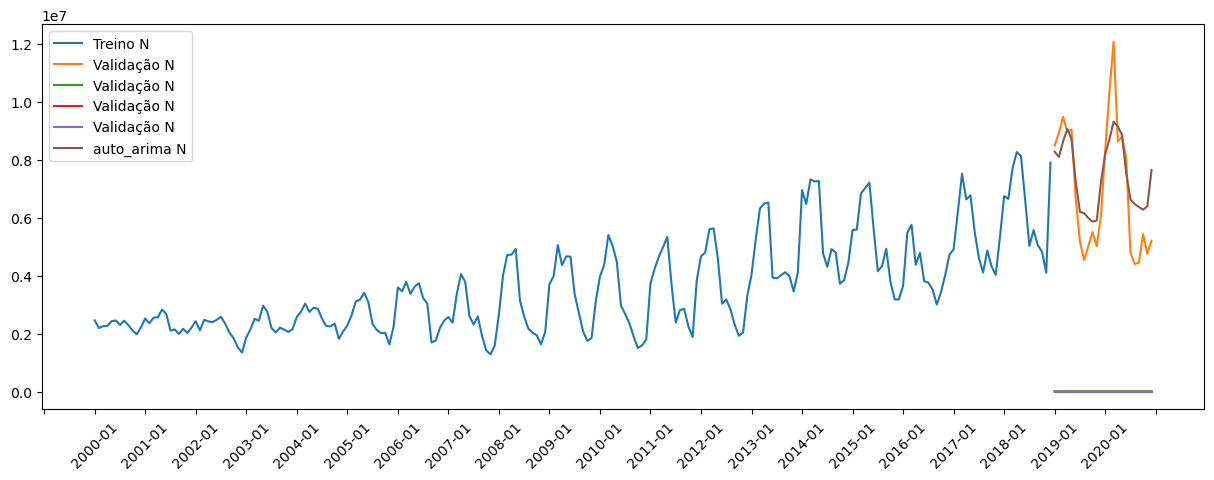

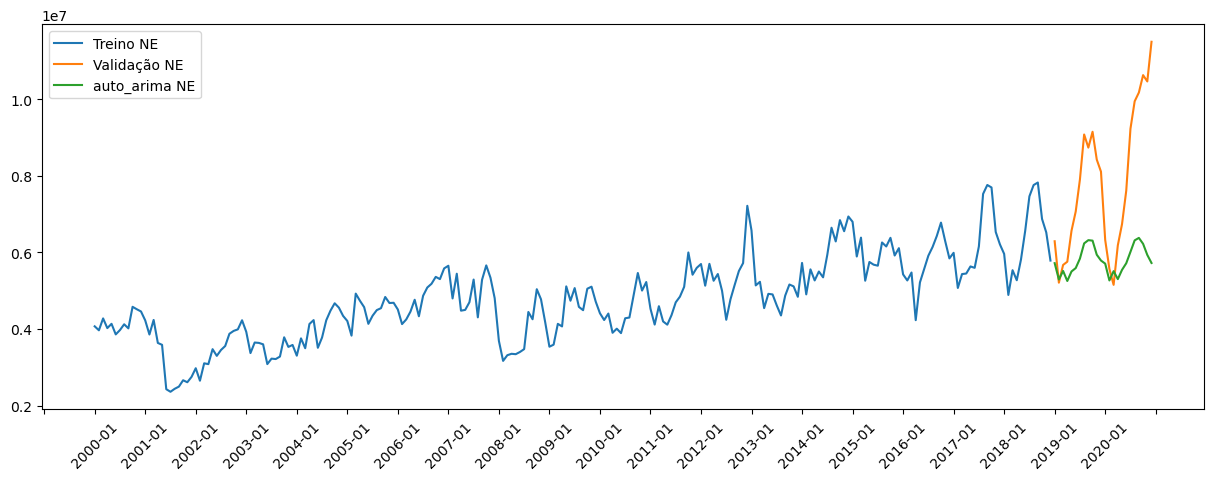

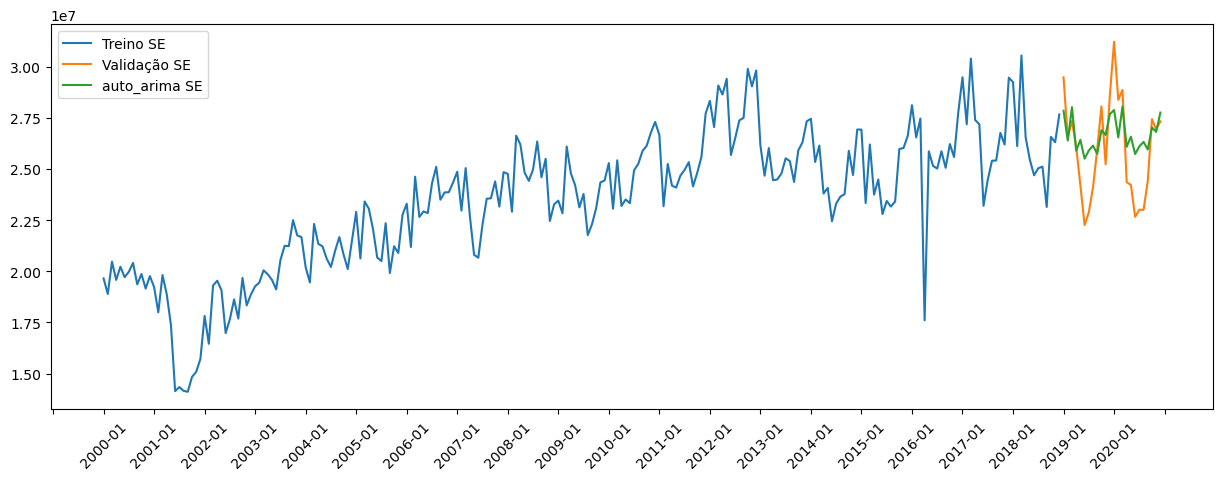

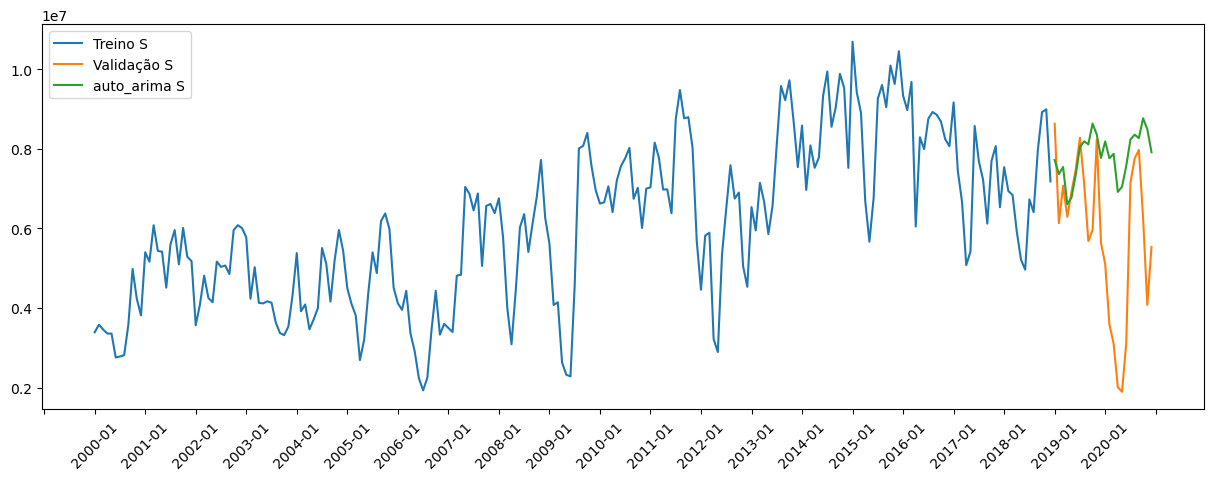

In [339]:
plt.figure(figsize = (15,5))
plt.plot(norte, label='Treino N')
plt.plot(Vnorte, label='Validação N')
plt.plot(forecastN, label='auto_arima N')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (15,5))
plt.plot(nordeste, label='Treino NE')
plt.plot(Vnordeste, label='Validação NE')
plt.plot(forecastNE, label='auto_arima NE')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (15,5))
plt.plot(sudeste, label='Treino SE')
plt.plot(Vsudeste, label='Validação SE')
plt.plot(forecastSE, label='auto_arima SE')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (15,5))
plt.plot(sul, label='Treino S')
plt.plot(Vsul, label='Validação S')
plt.plot(forecastS, label='auto_arima S')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
plt.xticks(rotation = 45)
plt.show()

In [334]:
#model.plot_diagnostics(figsize=(12, 8))
#plt.show()

          val_geracao
data                 
2019-01  8.487387e+06
2019-02  8.908365e+06
2019-03  9.475071e+06
2019-04  8.963661e+06
2019-05  9.037046e+06
2019-06  6.650196e+06
2019-07  5.179064e+06
2019-08  4.540511e+06
2019-09  5.018144e+06
2019-10  5.502931e+06
2019-11  5.015628e+06
2019-12  6.068074e+06
2020-01  8.315608e+06
2020-02  1.033827e+07
2020-03  1.206019e+07
2020-04  8.628161e+06
2020-05  8.782626e+06
2020-06  8.045377e+06
2020-07  4.783422e+06
2020-08  4.407247e+06
2020-09  4.448582e+06
2020-10  5.431709e+06
2020-11  4.755507e+06
2020-12  5.206747e+06


Text(0.5, 1.0, 'Série histórica e comparação de métodos')

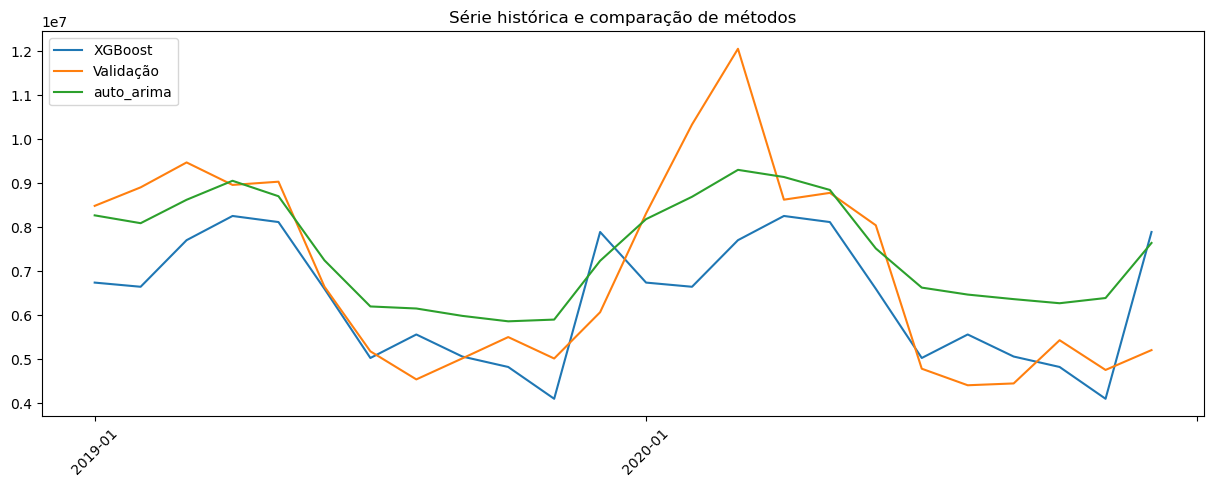

In [335]:
# define model
model = xgb.XGBRegressor()
norte['data'] = norte.index
norte['data'] = pd.to_datetime(norte['data'])
norte['mes'] = norte['data'].dt.month
norte['ano'] = norte['data'].dt.year

validN = Vnorte
Vnorte['data'] = Vnorte.index
vv = Vnorte['data']
Vnorte['data'] = pd.to_datetime(Vnorte['data'])
Vnorte['mes'] = Vnorte['data'].dt.month
Vnorte['ano'] = Vnorte['data'].dt.year
xtnorte = pd.DataFrame()
xtnorte['ano'] = Vnorte['ano']
xtnorte['mes'] = Vnorte['mes']
xnorte = pd.DataFrame()
xnorte['ano'] = norte['ano']
xnorte['mes'] = norte['mes']


model.fit(xnorte, norte['val_geracao'])

yhat = pd.DataFrame(model.predict(xtnorte))
yhat.index = vv.index
norte = norte.drop(['data', 'mes', 'ano'], axis = 1)
validN = validN.drop(['data', 'mes', 'ano'], axis = 1)
#print(norte)
print(validN)
plt.figure(figsize = (15,5))
#plt.plot(norte, label = 'Histórico')
plt.plot(yhat, label = 'XGBoost')
plt.plot(validN, label = 'Validação')
plt.plot(forecast, label='auto_arima')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12));
plt.xticks(rotation = 45);
plt.title('Série histórica e comparação de métodos')